# Mapping salt in 2-D seismic image using a U-Net
This tutorial describes how to map salt in a 2-D seismic image using a U-Net type convolutional neural network. A U-Net is network, which is able to predict the label of each pixel of an image, thus allowing much faster predictions than pixel-wise classification models (tutorial-1).[link text](https://)

## Setup ##

1. First, you will need sign in to your Google account. If you're not signed in, you can sign in [here](https://myaccount.google.com/?utm_source=sign_in_no_continue)
2. Next, head on to the [Colab Welcome Page](https://colab.research.google.com/notebooks/welcome.ipynb#recent=true).
3. There, select Github in the top tab and search for https://github.com/thilowrona/seismic_deep_learning/blob/master/tutorial-2/tutorial-2.ipynb
4. Clicking opens this notebook. This is a Jupyter notebook; an awesome combination of code and documentation allowing us work on, describe and share our projects.
5. Before running anything in here, you need to tell Colab that would like to use a GPU (important to train our models quickly). This is done by clicking on the ‘Runtime’ tab, selecting ‘Change runtime type’, changing hardware accelerator to ´GPU´ and clicking ´save´. Excellent! Colab is now set up!
6. When you run the first cell, you will face a pop-up saying ‘Warning: This notebook was not authored by Google’; you should click on ‘Run Anyway’ to get rid of the warning.
7. Next we want to save our notebook. If you click on ‘File’ and then ‘Save’, you will see a pop-up saying ´CANNOT SAVE CHANGES´. Now, click on ‘SAVE A COPY IN DRIVE’. This opens up a new tab with the same file, but this time located in your Drive. If you want to continue working after saving, use the file in the new tab. Your notebook will be saved in a folder called Colab Notebooks in your Google Drive by default.


## Pre-processing ##
Now that everything is set up, we want to load our data, but first we need to load a couple of useful python packages:


In [20]:
from sys import stdout

import random
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf

Next we clone the Github repository to get our data:

In [2]:
!git clone https://github.com/thilowrona/seismic_deep_learning

Cloning into 'seismic_deep_learning'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 368 (delta 38), reused 6 (delta 1), pack-reused 281
Receiving objects: 100% (368/368), 11.25 MiB | 6.14 MiB/s, done.
Resolving deltas: 100% (174/174), done.


Now you can load and plot the seismic image and its mask:

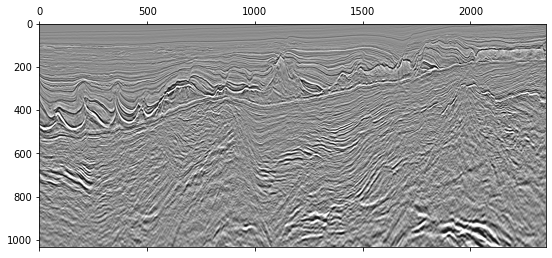

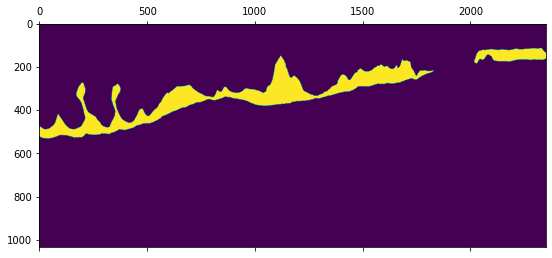

In [4]:
data = mpimg.imread('seismic_deep_learning/tutorial-2/seismic.tif')
data = data[:,:,:1]/255

mask = mpimg.imread('seismic_deep_learning/tutorial-2/mask.tif').copy()
mask = (mask-mask.min())/(mask.max()-mask.min())

plt.matshow(data[:,:,0], interpolation='spline16', cmap=plt.cm.gray, aspect=1)
plt.matshow(mask, interpolation='spline16', aspect=1)

So now we have one image with a mask, but we need many more examples to train a deep learning model. Of course, we could label more examples, but that takes time and additional data. Let's say we have neither of those. In this case, we can split up our image and mask in to many pairs of small patches. So let's do that:

In [11]:
patch_num  = 10000                               # Number of patches
patch_size = 128                                 # Patch size
val_split  = 0.2                                 # Validation split



def extract_patches(data, mask, patch_num, patch_size):

  X = np.empty((patch_num, patch_size, patch_size,1))
  Y = np.empty((patch_num, patch_size, patch_size,1))

  (t_max, x_max, _) = data.shape

  for n in range(patch_num):
      
      # Select random point in data (not too close to edge)   
      x_n = random.randint(patch_size//2,x_max-patch_size//2)
      t_n = random.randint(patch_size//2,t_max-patch_size//2)
      
      # Extract data and mask patch around point   
      X[n,:,:,0] = data[t_n-patch_size//2:t_n+patch_size//2,x_n-patch_size//2:x_n+patch_size//2,0]
      Y[n,:,:,0] = mask[t_n-patch_size//2:t_n+patch_size//2,x_n-patch_size//2:x_n+patch_size//2]


  return X, Y


X_train, Y_train = extract_patches(data[:,:1500], mask[:,:1500], int(patch_num*(1-val_split)), patch_size)
X_val,   Y_val   = extract_patches(data[:,1500:], mask[:,1500:], int(patch_num*(val_split)), patch_size)



Before training, it's always a good idea to look at the training data, so let's do that:

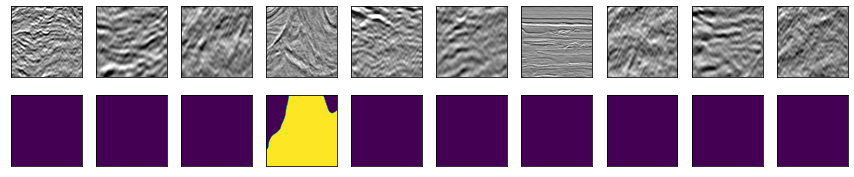

In [12]:
fig, axs = plt.subplots(2, 10, figsize=(15,3))

k = 0
for m in range(10):
  axs[0,m].imshow(X_train[k,:,:,0], interpolation='spline16', cmap=plt.cm.gray, aspect=1)
  axs[0,m].set_xticks([])
  axs[0,m].set_yticks([])
  k += 1

k = 0
for m in range(10):
  axs[1,m].imshow(Y_train[k,:,:,0], interpolation='spline16', aspect=1)
  axs[1,m].set_xticks([])
  axs[1,m].set_yticks([])
  k += 1


What do you notice?

* Is it an easy task?
* Could you predict the masks?
* Can we learn more from some examples?

### Training ##
To train our model, we need to define its architecture. 



In [22]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = tf.keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = tf.keras.layers.UpSampling2D((2, 2))(x)
    concat = tf.keras.layers.Concatenate()([us, skip])
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

  


def UNet():
  f = [16, 32, 64, 128, 256]
  inputs = tf.keras.layers.Input((patch_size, patch_size, 1))
  
  p0 = inputs
  c1, p1 = down_block(p0, f[0]) #128 -> 64
  c2, p2 = down_block(p1, f[1]) #64 -> 32
  c3, p3 = down_block(p2, f[2]) #32 -> 16
  c4, p4 = down_block(p3, f[3]) #16->8
  
  bn = bottleneck(p4, f[4])
  
  u1 = up_block(bn, c4, f[3]) #8 -> 16
  u2 = up_block(u1, c3, f[2]) #16 -> 32
  u3 = up_block(u2, c2, f[1]) #32 -> 64
  u4 = up_block(u3, c1, f[0]) #64 -> 128
  
  outputs = tf.keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
  model = tf.keras.models.Model(inputs, outputs)
  return model




model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])

Now you can train your first convolutional neural net:

In [23]:
history = model.fit(X_train, 
                    Y_train, 
                    validation_data=(X_val, Y_val), 
                    epochs=10)

Epoch 1/10
250/250 [==============================] - 50s 199ms/step - loss: 0.2070 - acc: 0.9328 - val_loss: 0.2238 - val_acc: 0.9121
Epoch 2/10
250/250 [==============================] - 49s 197ms/step - loss: 0.0862 - acc: 0.9687 - val_loss: 0.3045 - val_acc: 0.9287
Epoch 3/10
250/250 [==============================] - 49s 197ms/step - loss: 0.0408 - acc: 0.9839 - val_loss: 0.3122 - val_acc: 0.9443
Epoch 4/10
250/250 [==============================] - 49s 197ms/step - loss: 0.0267 - acc: 0.9885 - val_loss: 0.3229 - val_acc: 0.9504
Epoch 5/10
250/250 [==============================] - 49s 197ms/step - loss: 0.0109 - acc: 0.9940 - val_loss: 0.4922 - val_acc: 0.9448
Epoch 6/10
250/250 [==============================] - 49s 196ms/step - loss: 0.0080 - acc: 0.9950 - val_loss: 0.3027 - val_acc: 0.9555
Epoch 7/10
250/250 [==============================] - 49s 196ms/step - loss: 0.0109 - acc: 0.9941 - val_loss: 0.4986 - val_acc: 0.9485
Epoch 8/10
250/250 [==============================] - 4

To visualize our training, you can plot learning curves:

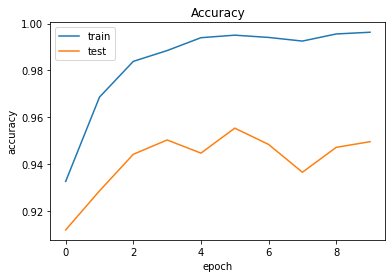

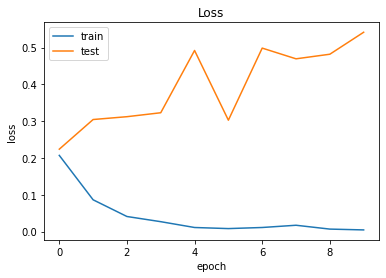

In [26]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##Application##
Finally, we can apply our model to the entire image to see how well it has learned to recognize salt structures in our seismic image. Since we predict every pixel of our patches, the prediction is much faster:

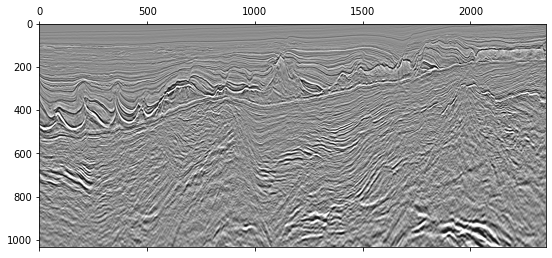

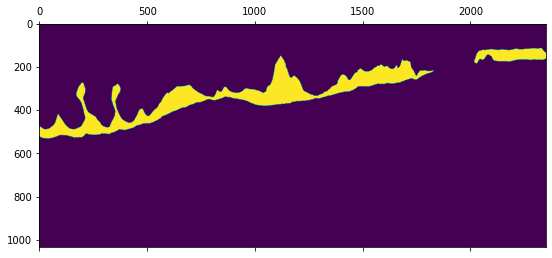

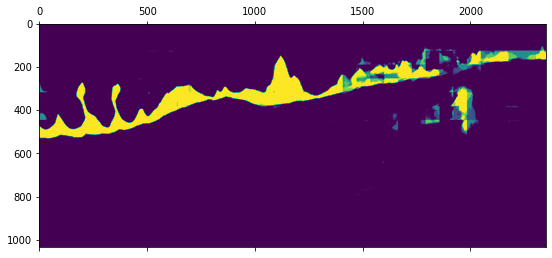

In [40]:
def tile(data, wsize, dt, dx):
    
    (t_max, x_max, _) = data.shape    
    
    n_patch = (t_max//dt+1)*(x_max//dx+1)
    data_patch = np.zeros((n_patch,wsize,wsize,1)) 

    n = 0
    for t in range(0, t_max, dt):
        for x in range(0, x_max, dx):    
            if t_max - t < wsize and x_max - x < wsize:
                data_patch[n,:,:,0] = data[t_max-wsize:t_max, x_max-wsize:x_max,0]
            elif x_max - x < wsize:
                data_patch[n,:,:,0] = data[t:t+wsize, x_max-wsize:x_max,0]
            elif t_max - t < wsize:
                data_patch[n,:,:,0] = data[t_max-wsize:t_max, x:x+wsize,0]
            else:
                data_patch[n,:,:,0] = data[t:t+wsize,x:x+wsize,0]  
            n = n + 1
    
    return data_patch 




def merge(data_patch, t_max, x_max, wsize, dt, dx):

    data_new = np.zeros((t_max, x_max,1))
    count = np.zeros((t_max, x_max, 1))
    
    n = 0
    for t in range(0, t_max, dt):
        for x in range(0, x_max, dx):
            if t_max - t < wsize and x_max - x < wsize:
                data_new[t_max-wsize:t_max, x_max-wsize:x_max,0] += data_patch[n,:,:,0]
                count[t_max-wsize:t_max, x_max-wsize:x_max,0] += 1
            elif x_max - x < wsize:
                data_new[t:t+wsize, x_max-wsize:x_max,0] += data_patch[n,:,:,0]
                count[t:t+wsize, x_max-wsize:x_max,0] += 1 
            elif t_max - t < wsize:
                data_new[t_max-wsize:t_max, x:x+wsize,0] += data_patch[n,:,:,0]
                count[t_max-wsize:t_max, x:x+wsize,0] += 1
            else:
                data_new[t:t+wsize,x:x+wsize,0] += data_patch[n,:,:,0]
                count[t:t+wsize,x:x+wsize,0] += 1 
            n = n + 1

    return data_new/count


dt = 64
dx = 64

(t_max, x_max, _) = data.shape

data_tiles = tile(data, patch_size, dt, dx)
result_tiles = model.predict_on_batch(data_tiles)
result = merge(result_tiles, t_max, x_max, patch_size, dt, dx)


plt.matshow(data[:,:,0], interpolation='spline16', cmap=plt.cm.gray, aspect=1)
plt.matshow(mask, interpolation='spline16', aspect=1)
plt.matshow(result[:,:,0], interpolation='spline16', aspect=1)
plt.show()



Awesome! The model did a pretty good job on the training data (left side of the image), but on yet unseen data (right side of the image), it struggles a bit. In the next tutorial ([tutorial-3](https://github.com/thilowrona/seismic_deep_learning/blob/master/tutorial-3/tutorial_3.ipynb)), we will see what we can do about this
